In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pickle
import json
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import _utilities

In [2]:
with open( './cells_of_interest.json', 'r') as f:
   cells_of_interest = json.load(f)

In [3]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
cells_info['ABal']

{'mother_cell': 'ABa',
 'daughter_cells': ['ABala', 'ABalp'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0      14  17.16  23.98  19
  1      15  16.72  26.18  18
  2      16  16.94  27.50  16
  3      17  16.50  28.82  16
  4      18  14.74  28.82  18
  5      19  14.52  28.38  18
  6      20  14.74  27.72  19
  7      21  14.30  28.60  19
  8      22  13.86  28.38  18
  9      23  13.42  28.38  17
  10     24  13.20  28.82  16
  11     25  13.86  28.16  15
  12     26  14.52  26.62  16,
  'WT-EMB02':     frame      x      y   z
  0      25  16.94  23.54  13
  1      26  17.16  25.96  15
  2      27  17.38  26.62  16
  3      28  16.28  26.62  15
  4      29  14.52  26.40  14
  5      30  13.64  25.96  13
  6      31  14.30  25.30  13
  7      32  13.86  27.94  14
  8      33  14.08  26.84  15
  9      34  13.86  26.40  16
  10     35  14.08  25.96  15
  11     36  15.18  24.64  17
  12     37  16.28  23.98  16,
  'WT-EMB03':     frame      x      y   z
  0      12 

In [4]:
with open('./embryo_cells_info.pickle', 'rb') as f:
    embryo_cells_info = pickle.load(f)
embryo_cells_info['WT-EMB12']['ABal']

{'trajectory_processed':     frame          x         y         z
 0       1 -17.149992  0.614791  1.585662
 1       2 -16.269992  2.154791  1.585662
 2       3 -16.709992  4.354791  1.585662
 3       4 -18.249992  4.574791  3.585662
 4       5 -19.789992  3.474791  4.585662
 5       6 -20.889992  2.374791  3.585662
 6       7 -21.329992  4.354791  2.585662
 7       8 -21.109992  3.254791  2.585662
 8       9 -21.109992  3.034791  2.585662
 9      10 -20.889992  3.474791  0.585662
 10     11 -20.229992  2.814791 -1.414338,
 'trajectory_processed_txyz':      time          x         y         z
 0    1.25 -17.149992  0.614791  1.585662
 1    2.50 -16.269992  2.154791  1.585662
 2    3.75 -16.709992  4.354791  1.585662
 3    5.00 -18.249992  4.574791  3.585662
 4    6.25 -19.789992  3.474791  4.585662
 5    7.50 -20.889992  2.374791  3.585662
 6    8.75 -21.329992  4.354791  2.585662
 7   10.00 -21.109992  3.254791  2.585662
 8   11.25 -21.109992  3.034791  2.585662
 9   12.50 -20.889992 

In [5]:
embryos_for_test = ['WT-EMB05','WT-EMB12','WT-EMB19','WT-EMB26']
embryos_for_cross_validation = [embryo_name for embryo_name in embryo_cells_info if embryo_name not in embryos_for_test]

In [6]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [7]:
len(embryos_for_cross_validation)

24

# 1. Random Forest with all features 

# Cross-Validation results

In [ ]:
# changing n_estimators in the forest
rf_cv_score = []
for i in tqdm(range(6)): # 6-fold cross-validation
    # train and val dataset
    embryos_val = embryos_for_cross_validation[4*i:4*i+4]
    embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
    X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
    X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
    X_train, y_train = shuffle(X_train, y_train, random_state=1)
    # X_val, y_val = shuffle(X_val, y_val, random_state=1)
    scores = []
    for n_trees in range(10, 201):
        forest = RandomForestClassifier(n_estimators=n_trees, random_state=1, n_jobs=10)
        forest.fit(X_train, y_train)
        scores.append(forest.score(X_val, y_val))
    rf_cv_score.append(scores.copy())

In [10]:
with open( './rf_cv_score_all_features.json', 'w') as f:
   json.dump(rf_cv_score, f)

In [8]:
with open( './rf_cv_score_all_features.json', 'r') as f:
   rf_cv_score = json.load(f)

In [9]:
np.array(rf_cv_score).shape

(6, 191)

In [10]:
-np.sort(-np.mean(rf_cv_score, axis=0))

array([0.92065868, 0.92053393, 0.92053393, 0.92040918, 0.92028443,
       0.91991018, 0.91991018, 0.91978543, 0.91978543, 0.91978543,
       0.91978543, 0.91978543, 0.91978543, 0.91966068, 0.91966068,
       0.91966068, 0.91966068, 0.91953593, 0.91953593, 0.91953593,
       0.91953593, 0.91941118, 0.91941118, 0.91941118, 0.91941118,
       0.91928643, 0.91928643, 0.91928643, 0.91928643, 0.91928643,
       0.91916168, 0.91916168, 0.91916168, 0.91916168, 0.91903693,
       0.91903693, 0.91903693, 0.91903693, 0.91891218, 0.91891218,
       0.91891218, 0.91891218, 0.91878743, 0.91878743, 0.91878743,
       0.91866267, 0.91866267, 0.91853792, 0.91853792, 0.91841317,
       0.91828842, 0.91816367, 0.91803892, 0.91803892, 0.91791417,
       0.91791417, 0.91778942, 0.91778942, 0.91766467, 0.91766467,
       0.91766467, 0.91753992, 0.91753992, 0.91753992, 0.91741517,
       0.91741517, 0.91741517, 0.91741517, 0.91729042, 0.91729042,
       0.91729042, 0.91729042, 0.91729042, 0.91729042, 0.91716

In [11]:
np.argsort(-np.mean(rf_cv_score, axis=0))+10 # n_trees

array([194, 191, 193, 195, 192, 174, 197, 199, 196, 198, 168, 181, 189,
       190, 188, 180, 182, 172, 187, 175, 176, 178, 170, 167, 169, 171,
       177, 166, 184, 156, 158, 200, 183, 173, 163, 157, 161, 159, 164,
       185, 162, 179, 165, 153, 155, 160, 186, 152, 151, 154, 149, 147,
       150, 146, 104, 139, 148, 138, 145, 130, 137, 142, 123, 144,  58,
        98, 136,  99, 114, 108, 107, 103, 120, 141, 106, 134, 102, 128,
        97, 105, 143, 100,  78, 124, 133, 132, 140, 121, 122, 125, 129,
       118, 135, 117,  96, 126,  80,  92, 111, 112, 116, 119, 131, 127,
        95,  79, 115, 101,  68,  90, 110, 109,  94, 113,  59,  57,  91,
        48,  69,  81,  93,  49,  56,  85,  88,  77,  76,  84,  86,  55,
        51,  70,  67,  53,  83,  82,  60,  74,  87,  89,  61,  66,  54,
        65,  73,  75,  64,  52,  71,  72,  50,  46,  62,  47,  63,  44,
        43,  42,  45,  41,  39,  38,  40,  37,  36,  32,  34,  35,  33,
        30,  31,  28,  27,  29,  26,  25,  23,  24,  22,  21,  1

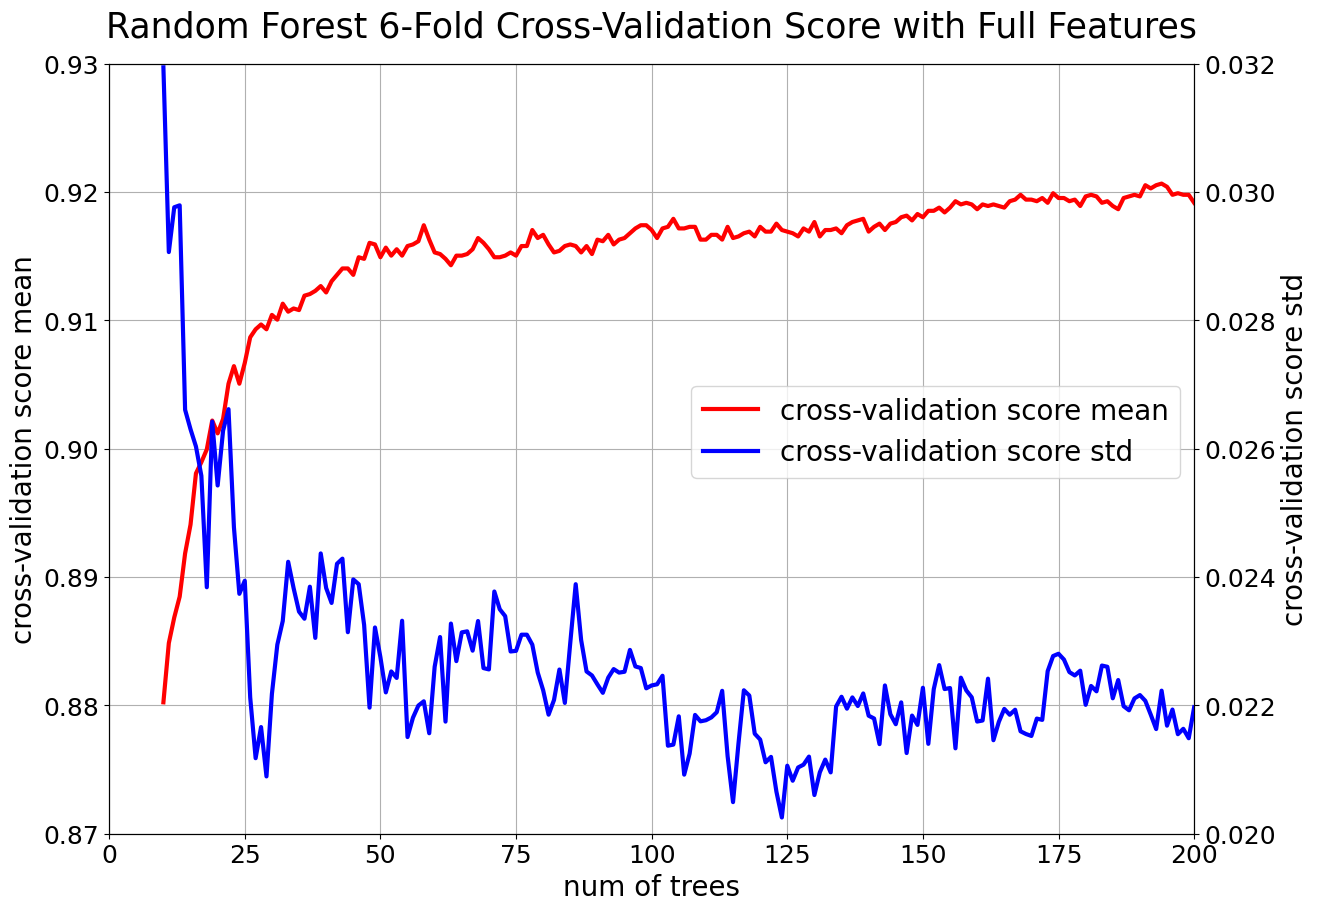

In [12]:
# plot num_trees vs cross_validation score mean and std
fig, ax1 = plt.subplots(figsize = (14,10))
ax1.plot(range(10,201),np.mean(rf_cv_score, axis=0), label = 'cross-validation score mean', color = 'r', linewidth = 3)
ax2 = ax1.twinx()
ax2.plot(range(10,201),np.std(rf_cv_score, axis=0), label = 'cross-validation score std', color = 'b', linewidth = 3)
ax1.grid()
ax1.set_xlim(0,200)
ax1.set_ylim(0.87, 0.93)
ax2.set_ylim(0.020, 0.032)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('num of trees', fontsize = 20)
ax1.set_ylabel('cross-validation score mean', fontsize = 20)
ax2.set_ylabel('cross-validation score std', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(1,0.6), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('Random Forest 6-Fold Cross-Validation Score with Full Features', fontsize = 25, y = 1.025)
fig.savefig('./random_forest_full_features_6_fold_cv_score.png')

# on 4 test samples

In [13]:
n_trees = 194 # as our best model    
rf_test_score = []

# use all embryos_for_cross_validation data to retrain the model and test on the test embryo samples
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_cross_validation, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_train, y_train = shuffle(X_train, y_train, random_state=1)
forest = RandomForestClassifier(n_estimators=n_trees, random_state=1, n_jobs=10)
forest.fit(X_train, y_train)
test_accuracy = forest.score(X_test, y_test)
print(f'Random Forest with full features, n_trees = {n_trees} accuracy on test embryos:', test_accuracy)

Random Forest with full features, n_trees = 194 accuracy on test embryos: 0.9318862275449101


In [15]:
np.argsort(-forest.feature_importances_)

array([202,   1,   5,   2,   9,  13,   6,  17,  10,  21,  25,  14,  33,
        29,  49,  45,  18,  37,  41,  53,  22, 203,  82,  74,  65,  73,
        61,  78,  57,  70,  69,  85,  26,  30,  86,  50,  90,  98,  38,
        81,  93,  42,  89,  34, 105,  62,  66, 101, 102,  94,  58,  54,
        97, 109,  46,  77, 106, 110, 113, 117, 121, 114, 201, 118, 125,
       129, 122, 133, 126, 130, 137,  44,  12,  36,  40, 200, 134,   8,
       145,   0, 206,  24, 209,  48,  16,  52, 141,  68,   4,  32,  28,
        56,  20,  64, 205,  60, 138, 149,  72, 142,  84,  88, 108,  80,
       112,  76, 208, 146, 111, 116, 153,  92, 104, 119,  96, 107, 150,
       115, 103,  75, 132, 100, 136,   7, 120,  67, 123,  83,  71, 124,
        99, 131,  95,  79,  51,  91, 154,  87,  63, 128,   3,  15,  27,
        55, 144,  11, 147,  39,  23, 157, 139, 135,  19,  59, 152, 140,
       155,  31,  47, 148,  43,  35, 127, 143, 151, 158, 204, 156, 159,
       210, 161, 207, 162, 160, 163, 166, 165, 167, 164, 169, 17

From the feature importance above:
1. **'division_orientation_to_mother_cell' along X axis (A/P axis) (202)** is the most important feature. 
   - this is reasonable. As most cells are born in A/P division cases, and this can distinguish their name suffix to be 'a' or 'p'. <br/>
2. The next important feature is **trajectory (0-199)**, 
3. then is **lifespan (201)**
4. then is **start_time (200)**. 
5. Then comes **'division_orientation_of_daughter_cells (206, 209)'**, the two daughter cells' division orientations along y axis (L/R axis).

# 2. Random Forest with only Trajectory features